In [1]:
import pandas as pd
import numpy as np

In [2]:
import sys
sys.path.append("/home/mizworski/Repos/xgboost/python-package/")

In [3]:
df = pd.read_csv('../data/bank-classification.csv', index_col=0)
df = df.sample(frac=1)

In [4]:
df_train = df[df.y != 'unknown']

In [5]:
df_train.head()

,birth_date,job,marital,education,default,housing,loan,contact_date,contact,campaign,pdays,previous,poutcome,y
id,,,,,,,,,,,,,,
3892,1971-05-07,technician,married,basic.9y,no,no,no,2008-05-30,telephone,3,999,0,nonexistent,no
280,1957-03-18,retired,married,professional.course,no,no,no,2008-05-19,telephone,3,999,0,nonexistent,no
6953,1973-03-04,services,married,high.school,no,no,no,2008-05-01,telephone,1,999,0,nonexistent,no
6973,1970-03-06,technician,married,basic.9y,no,no,no,2008-05-01,telephone,3,999,0,nonexistent,no
12206,1958-11-08,blue-collar,divorced,basic.9y,no,no,no,2008-07-09,telephone,3,999,0,nonexistent,no


In [6]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [7]:
target = df_train['y']
target.value_counts()

no     18419
yes     2380
Name: y, dtype: int64

In [8]:
df_train = df_train.drop('y', axis=1)
df_train.head()

,birth_date,job,marital,education,default,housing,loan,contact_date,contact,campaign,pdays,previous,poutcome
id,,,,,,,,,,,,,
3892,1971-05-07,technician,married,basic.9y,no,no,no,2008-05-30,telephone,3,999,0,nonexistent
280,1957-03-18,retired,married,professional.course,no,no,no,2008-05-19,telephone,3,999,0,nonexistent
6953,1973-03-04,services,married,high.school,no,no,no,2008-05-01,telephone,1,999,0,nonexistent
6973,1970-03-06,technician,married,basic.9y,no,no,no,2008-05-01,telephone,3,999,0,nonexistent
12206,1958-11-08,blue-collar,divorced,basic.9y,no,no,no,2008-07-09,telephone,3,999,0,nonexistent


In [9]:
Y = pd.get_dummies(target, drop_first=True)

In [10]:
Y.head()

,yes
id,
3892,0
280,0
6953,0
6973,0
12206,0


In [11]:
categorical_cols = list(set(df_train.columns) - set(['birth_date', 'contact_date', 'pdays', 'campaign']))

X = pd.get_dummies(df_train, columns=categorical_cols, drop_first=True)

In [12]:
X.head()

,birth_date,contact_date,campaign,pdays,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,...,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,marital_unknown
id,,,,,,,,,,,,,,,,,,,,,
3892,1971-05-07,2008-05-30,3,999,0,1,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
280,1957-03-18,2008-05-19,3,999,0,0,0,0,1,0,...,1,0,0,0,0,0,0,1,0,0
6953,1973-03-04,2008-05-01,1,999,0,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0
6973,1970-03-06,2008-05-01,3,999,0,1,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
12206,1958-11-08,2008-07-09,3,999,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
# X['contacted'] = pd.get_dummies(X['pdays'] < 999)
X['contacted'] = pd.get_dummies(X.pdays < 999, drop_first=True)

In [14]:
from datetime import datetime

In [15]:
date_parse_format = '%Y-%m-%d'
datetime.strptime(X.iloc[0]['birth_date'], date_parse_format)

datetime.datetime(1971, 5, 7, 0, 0)

In [16]:
(datetime.now() - datetime.strptime(X.iloc[0]['birth_date'], date_parse_format)).days

17009

In [17]:
now = datetime.strptime(X.contact_date.max(), date_parse_format)

In [18]:
X['age'] = X.apply(lambda r: int((now - datetime.strptime(r.birth_date, date_parse_format)).days / 365.25), axis=1)

In [19]:
X.drop('birth_date', axis=1, inplace=True)

In [20]:
X['days_since_contact'] =  X.apply(lambda r: int((now - datetime.strptime(r.contact_date, date_parse_format)).days), axis=1)

In [21]:
X.drop('contact_date', axis=1, inplace=True)

In [22]:
X.head()

,campaign,pdays,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,poutcome_nonexistent,...,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,marital_unknown,contacted,age,days_since_contact
id,,,,,,,,,,,,,,,,,,,,,
3892,3,999,0,1,0,0,0,0,0,1,...,0,1,0,0,1,0,0,0,39,914
280,3,999,0,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,53,925
6953,1,999,0,0,1,0,0,0,0,1,...,0,0,0,0,1,0,0,0,37,943
6973,3,999,0,1,0,0,0,0,0,1,...,0,1,0,0,1,0,0,0,40,943
12206,3,999,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,52,874


In [23]:
# model.fit(X, Y)

In [24]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

In [26]:
# model.fit(X, Y)

In [27]:
from sklearn.utils.validation import column_or_1d
from scipy import interp

In [28]:
Y = column_or_1d(Y)

In [29]:
X = X.as_matrix()

In [36]:
model = XGBClassifier()
cv = StratifiedKFold(n_splits=6)

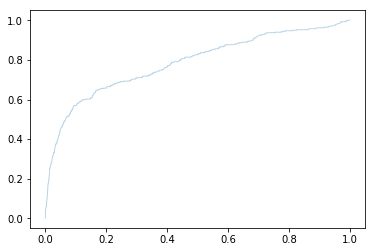

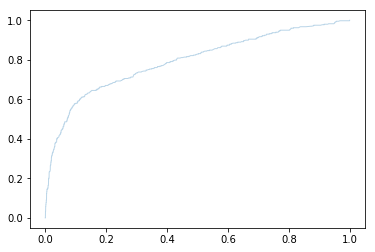

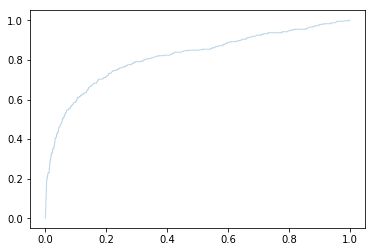

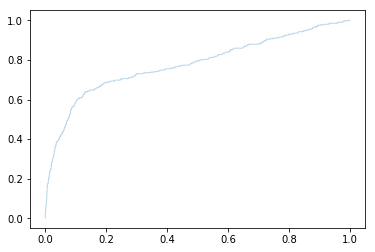

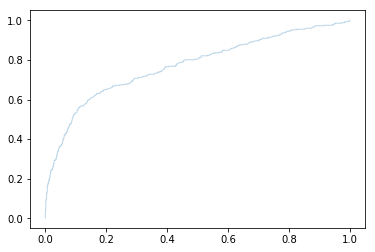

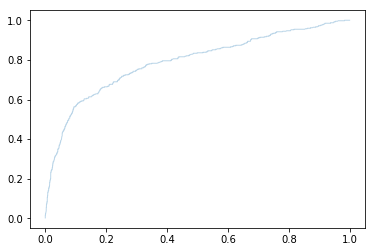

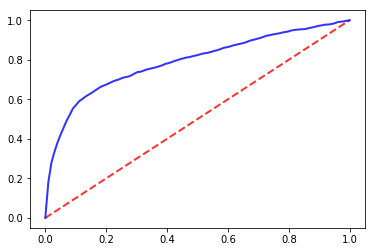

In [37]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
i=0
for train, test in cv.split(X, Y):
    probas_ = model.fit(X[train], Y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(Y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    plt.show()

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

plt.show()

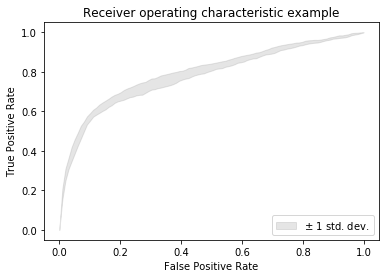

In [38]:
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [33]:
mean_auc

0.78853742223509171

In [35]:
def preprocess_X(data):
#     df_train = df_train.drop('y', axis=1)
# df_train.head()
    categorical_cols = list(set(data.columns) - set(['birth_date', 'contact_date', 'pdays', 'campaign']))

    X = pd.get_dummies(data, columns=categorical_cols, drop_first=True)
    X['contacted'] = pd.get_dummies(X.pdays < 999, drop_first=True)
    now = datetime.strptime(X.contact_date.max(), date_parse_format)
    X['age'] = X.apply(lambda r: int((now - datetime.strptime(r.birth_date, date_parse_format)).days / 365.25), axis=1)
    X.drop('birth_date', axis=1, inplace=True)
    X['days_since_contact'] =  X.apply(lambda r: int((now - datetime.strptime(r.contact_date, date_parse_format)).days), axis=1)
    X.drop('contact_date', axis=1, inplace=True)
    
    train_x = data[data.y != 'unknown']
    test_x = data[data.y == 'unknown']
    train_y = train_x['y']
    train_y = pd.get_dummies(train_y, drop_first=True)
    train_x = train_x.drop('y', axis=1)
    test_x = test_x.drop('y', axis=1)
    
    train_y = column_or_1d(train_y)
    train_x = train_x.as_matrix()
    test_x = text_x.as_matrix()
    
    return train_x, train_y, test_x
    